In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from tqdm import tqdm

In [2]:
df = pd.read_csv("daily-minimum-temperatures-in-me.csv")
df['Daily minimum temperatures'] = df['Daily minimum temperatures'].str.strip('?').astype(float)
df.columns = ['Date', 'Tempreature']

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by = "Date")

<Axes: xlabel='Date'>

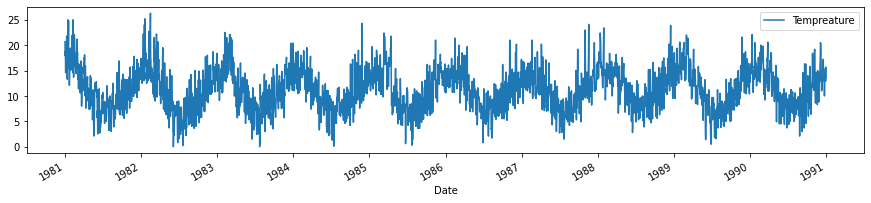

In [4]:
df.plot(x='Date', y='Tempreature', figsize=(15, 3))

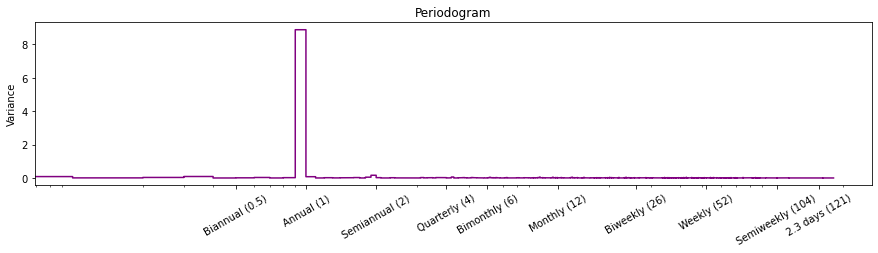

In [5]:
freqencies, spectrum = periodogram(
        df['Tempreature'],
        fs=365,
        detrend='linear',
        window="boxcar",
        scaling='spectrum',
    )

plt.figure(figsize=(15, 3))
plt.step(freqencies, spectrum, color="purple")
plt.xscale("log")
plt.xticks([0.5, 1, 2, 4, 6, 12, 26, 52, 104, 158],
          [
        "Biannual (0.5)",
        "Annual (1)",
        "Semiannual (2)",
        "Quarterly (4)",
        "Bimonthly (6)",
        "Monthly (12)",
        "Biweekly (26)",
        "Weekly (52)",
        "Semiweekly (104)",
        "2.3 days (121)"
    ],rotation=30)
plt.ylabel("Variance")
plt.title("Periodogram")
plt.show()

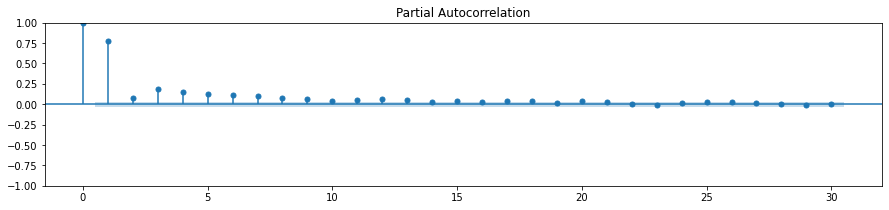

In [6]:
fig, ax = plt.subplots(1,1,figsize=(15,3))
plot_pacf(df['Tempreature'], lags=30, ax=ax)
plt.show()

In [10]:
def forecast(dataframe, days):

    future = pd.DataFrame(columns = dataframe.columns)
    future['Date'] = pd.date_range(dataframe['Date'].iloc[-1]+pd.Timedelta(1, "D"), dataframe['Date'].iloc[-1]+pd.Timedelta(days, "D"))
    df = pd.concat([dataframe, future])

    # Time feature creation
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.day_of_week
    
    # Days and trend
    dates = df['Date'].unique()
    days = np.arange(1, len(dates)+1)
    days = pd.DataFrame({"Date":dates, "Day":days})
    df = df.merge(days, on="Date", how="left")
    df['Trend'] = np.sqrt(df['Day'])
    
    # Seasonality features
    Seasonality = dict(zip(
        (365,),
        ('Annual',)
    ))
    for s, n in Seasonality.items():
        df[f'sin_{n}'] = np.sin(df['Day'] * (2*np.pi / s))
        df[f'cos_{n}'] = np.cos(df['Day'] * (2*np.pi / s))
        
    # Lag features
    lags = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    lagged = pd.concat({
        f'lag_{lag}': df['Tempreature'].shift(lag) for lag in lags
    }, axis=1)
    
    
    df = pd.concat([df, lagged], axis=1)[lags[-1]:]

    X = df.dropna().drop(columns = ['Tempreature', 'Date'])
    y = df.dropna()['Tempreature']

    display(X)
    
    model = Ridge()
    model.fit(X, y)
    
    for i in (range(df[df['Tempreature'].isna()]['Date'].nunique())):
        date_X = df[df['Tempreature'].isna()]['Date'].iloc[0]
        lead_X = df[df['Date'] == date_X]
#         display(lead_X)
        lead_1 = model.predict(lead_X.drop(columns = ['Tempreature', 'Date']))[0]

        try:
            df.loc[lead_X.index, 'Tempreature'] = lead_1
        except Exception as e:
            pass

        for lag in lags:
            index = df[df['Date'] == date_X + pd.Timedelta(lag, 'D')].index
            try:
                df.loc[index, f'lag_{lag}'] = lead_1
            except Exception as e:
                pass
            
    pred = df.iloc[-len(future):].set_index("Date")['Tempreature']
    return pred

,Year,Month,DayOfWeek,Day,Trend,sin_Annual,cos_Annual,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9
9,1981,1,5,10,3.162278,1.712931e-01,0.985220,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9,20.7
10,1981,1,6,11,3.316625,1.882267e-01,0.982126,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8,17.9
11,1981,1,0,12,3.464102,2.051045e-01,0.978740,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6,18.8
12,1981,1,1,13,3.605551,2.219215e-01,0.975065,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8,14.6
13,1981,1,2,14,3.741657,2.386728e-01,0.971100,16.7,13.3,16.2,20.0,21.8,17.4,15.8,15.8,15.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3645,1990,12,3,3646,60.382117,-6.880243e-02,0.997630,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7,17.2
3646,1990,12,4,3647,60.390397,-5.161967e-02,0.998667,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4,14.7
3647,1990,12,5,3648,60.398675,-3.442161e-02,0.999407,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1,15.4
3648,1990,12,6,3649,60.406953,-1.721336e-02,0.999852,13.5,13.6,14.0,14.6,12.9,10.0,13.9,13.2,13.1


<Axes: xlabel='Date'>

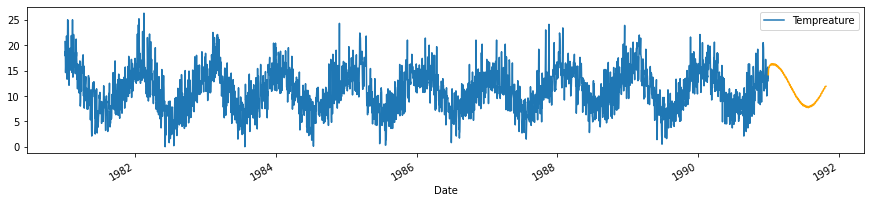

In [11]:
ax = df.plot(x='Date', y='Tempreature', figsize=(15, 3))
forecast(df, 300).plot(ax = ax, c = 'orange')

In [18]:
len(df)

3650

In [12]:
df['Tempreature'] = df['Tempreature']

,Date,Tempreature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7
